### Graph dataset

In [1]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GAE

from torch_geometric.utils import to_networkx

from torch_geometric.loader import DataLoader
torch.manual_seed(12345)


In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [3]:
from src.graph.dataset import DaylightDataset

In [4]:
d = DaylightDataset("../graph")
_ = d.process()

In [ ]:
from __future__ import annotations
from dataclasses import dataclass
import numpy as np

@dataclass(frozen=True)
class PipelineInput:
    dataset: DaylightDataset
    train: DataLoader
    val: DataLoader
    model: torch.nn.Module


class Step:
    @classmethod
    def run(cls, inp:PipelineInput)->PipelineInput:
        return cls._run(inp)
    
    @classmethod
    def _run(cls, inp:PipelineInput)->PipelineInput:
        return inp
    

class DataLoadStep(Step):
    
    @classmethod
    def _run(cls, inp:PipelineInput)->PipelineInput:
        return
    
class DataProcessStep(Step):
    batch = 100

    @classmethod
    def _split(cls, d:DaylightDataset)->tuple[DaylightDataset, DaylightDataset]:
        percent = np.ceil(len(d) * 0.8)
        dataset = d.shuffle()
        return (dataset[:percent], dataset[percent:])
    
    @classmethod
    def _run(cls, inp:PipelineInput)->PipelineInput:
        train_ds, val_ds = cls._split(inp.dataset)
        # print(f'Number of training graphs: {len(train_ds)}')
        # print(f'Number of test graphs: {len(val_ds)}')
        train_loader = DataLoader(train_ds, batch_size=cls.batch, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=cls.batch, shuffle=False)
        
        # for step, data in enumerate(train_loader):
        #     print(f'Step {step + 1}:')
        #     print('=======')
        #     print(f'Number of graphs in the current batch: {data.num_graphs}')
        #     print(data)
        #     print()
        return PipelineInput(inp.dataset, train_loader, val_loader, None)
        

class ModelBuildStep(Step):
    
    @classmethod
    def _run(cls, inp:PipelineInput)->PipelineInput:
        return

Number of training graphs: 800
Number of test graphs: 200
Step 1:
Number of graphs in the current batch: 100
DataBatch(x=[914, 7], edge_index=[2, 1798], batch=[914], ptr=[101])

Step 2:
Number of graphs in the current batch: 100
DataBatch(x=[903, 7], edge_index=[2, 1785], batch=[903], ptr=[101])

Step 3:
Number of graphs in the current batch: 100
DataBatch(x=[912, 7], edge_index=[2, 1808], batch=[912], ptr=[101])

Step 4:
Number of graphs in the current batch: 100
DataBatch(x=[896, 7], edge_index=[2, 1754], batch=[896], ptr=[101])

Step 5:
Number of graphs in the current batch: 100
DataBatch(x=[888, 7], edge_index=[2, 1748], batch=[888], ptr=[101])

Step 6:
Number of graphs in the current batch: 100
DataBatch(x=[920, 7], edge_index=[2, 1820], batch=[920], ptr=[101])

Step 7:
Number of graphs in the current batch: 100
DataBatch(x=[908, 7], edge_index=[2, 1782], batch=[908], ptr=[101])

Step 8:
Number of graphs in the current batch: 100
DataBatch(x=[894, 7], edge_index=[2, 1760], batch=[

In [38]:
def train(model, b, optimizer, criterion):
    model.train()
    optimizer.zero_grad()

    out, z = model(b.x, b.edge_index)
    loss = criterion(out, b.x)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, b1, criterion):
    model.eval()
    with torch.no_grad():
        out, z = model(b1.x, b1.edge_index)
        loss = criterion(out, b1.x)
        return loss

In [39]:
def test(model, loader, criterion):
    model.eval()
    loss = None
    for data in loader:  # Iterate in batches over the training/test dataset.
        out, _ = model(data.x, data.edge_index)  
        loss = criterion(out, data.x)
    return loss

In [56]:
out_channels = 2
num_features = d.num_features
model = GraphAutoencoder(num_features, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
early_stopping = EarlyStopping(patience=50, min_delta=0.001)
for epoch in range(1000):
    for batch in train_loader:
        loss = train(model, batch, optimizer, criterion)
    val_loss = test(model, test_loader, criterion)
    if (epoch % 10 ==0):
        print(f'Epoch {epoch+1}, Train loss: {loss} Loss: {val_loss}')
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print('Training complete.')

Epoch 1, Train loss: 0.22294557094573975 Loss: 0.20814724266529083
Epoch 11, Train loss: 0.08155786991119385 Loss: 0.07835352420806885
Epoch 21, Train loss: 0.04998799040913582 Loss: 0.04746510088443756
Epoch 31, Train loss: 0.04119078069925308 Loss: 0.040179912000894547
Epoch 41, Train loss: 0.0395866334438324 Loss: 0.03700149431824684
Epoch 51, Train loss: 0.03817928209900856 Loss: 0.03614649549126625
Epoch 61, Train loss: 0.03527112305164337 Loss: 0.034523457288742065
Epoch 71, Train loss: 0.03546348214149475 Loss: 0.033851414918899536
Epoch 81, Train loss: 0.0334065817296505 Loss: 0.03351810574531555
Epoch 91, Train loss: 0.03421708941459656 Loss: 0.03209898993372917
Epoch 101, Train loss: 0.03359078988432884 Loss: 0.0306084007024765
Epoch 111, Train loss: 0.030592026188969612 Loss: 0.029520142823457718
Epoch 121, Train loss: 0.029018133878707886 Loss: 0.02816743776202202
Epoch 131, Train loss: 0.02562830224633217 Loss: 0.02669668011367321
Epoch 141, Train loss: 0.02568430453538894

In [ ]:

G = to_networkx(d[100], to_undirected=True)
visualize_graph(G, color="red")

/tmp/ipykernel_125041/2470569930.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")


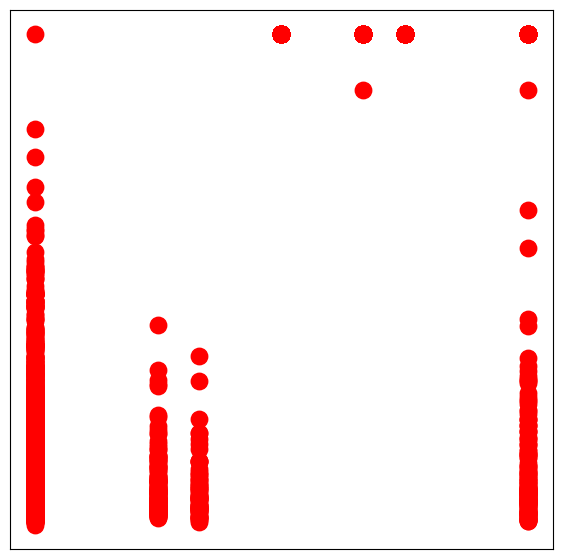

In [54]:
visualize_embedding(test_dataset.x, "red")

### Stats compute

In [5]:
from src.loaders.datasetloader import DatasetLoader

In [6]:
rooms = DatasetLoader.run("../compute/dataset_20250130/test_generation")

In [7]:
rooms[1]

Room(id='graph_10', graph=[{'from': 'Wall_001', 'to': 'Wall_002', 'angle': 90.0}, {'from': 'Wall_002', 'to': 'Wall_001', 'angle': 90.0}, {'from': 'Wall_002', 'to': 'Wall_003', 'angle': -90.0}, {'from': 'Wall_003', 'to': 'Wall_002', 'angle': -90.0}, {'from': 'Wall_003', 'to': 'Wall_004', 'angle': -90.0}, {'from': 'Wall_004', 'to': 'Wall_003', 'angle': -90.0}, {'from': 'Wall_004', 'to': 'Wall_005', 'angle': -90.0}, {'from': 'Wall_005', 'to': 'Wall_004', 'angle': -90.0}, {'from': 'Wall_005', 'to': 'Wall_006', 'angle': -90.0}, {'from': 'Wall_006', 'to': 'Wall_005', 'angle': -90.0}, {'from': 'Wall_006', 'to': 'Wall_001', 'angle': -90.0}, {'from': 'Wall_001', 'to': 'Wall_006', 'angle': -90.0}, {'from': 'Window_001', 'to': 'Wall_004', 'uv_coordinates': {'u': 0.53158, 'v': 0.58074}}, {'from': 'Balcony_001', 'to': 'Wall_004', 'uv_coordinates': {'u': 0.0, 'v': 0.61742}}], walls=[Wall(id='Wall_001', center=Coordinate(x=0, y=0, z=0), bb=Bbox(width=0.37, height=4.45, length=0.4466), props=WallProps

In [8]:
from src.stats.stat_calculator import StatCalculator

In [10]:
res = StatCalculator.run(rooms)

In [11]:
res

[StatResult(mean=np.float64(5.351851851851852), max=np.int64(6), min=np.int64(4)),
 StatResult(mean=np.float64(1.0), max=np.int64(1), min=np.int64(1)),
 StatResult(mean=np.float64(2.0), max=np.int64(2), min=np.int64(2)),
 StatResult(mean=np.float64(28.32965842592593), max=np.float64(90.848), min=np.float64(5.23582))]